In this project we need to answer some questions about Seattle AirBnB data. This data is about the calendar of prices and occupation, the listings and characteristics of the apartments and the reviews made by the roomers.
The questions for this project will be always comparing between the best rated hosts and the non-best ones:
 - What is the mean price the hosts offer? 
 - What is the mean occupation of the apartments?
 - Which are the most important words in the comments the roomers leave?
 - Is there a difference between the geographical distribution of the best hosts and the others?

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import CountVectorizer
from mpl_toolkits.basemap import Basemap

****
### 1. Gather
****

In [139]:
# Load Seattle data
seattle_calendar = pd.read_csv('seattle_calendar.csv')
seattle_listings = pd.read_csv('seattle_listings.csv')
seattle_reviews = pd.read_csv('seattle_reviews.csv')

In [140]:
print(seattle_calendar.shape)
print(seattle_listings.shape)
print(seattle_reviews.shape)

(1393570, 4)
(3818, 92)
(84849, 6)


****
### 2. Assess
#### Data Understanding
****

In [141]:
# Take a look at the data to see what can be obtained from this information
seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [142]:
seattle_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [143]:
seattle_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


****
### 3. Clean
#### Data Preparation
****

In [144]:
# Create useful columns for data, price and occupation
seattle_calendar['year_month'] = pd.to_datetime(seattle_calendar['date']).map(lambda x: str(x.month).zfill(2) + 
                                                                              '-' + str(x.year))

In [145]:
seattle_calendar['norm_price'] = (seattle_calendar['price'].fillna('')).map(lambda x: pd.to_numeric(x.replace('$', '')
                                                                                                     .replace('.00', '')
                                                                                                     .replace(',','')))

In [146]:
seattle_calendar.loc[seattle_calendar['available']=='f', 'Occupied'] = 1
seattle_calendar.loc[seattle_calendar['available']=='t', 'Free'] = 1
seattle_calendar[['Occupied', 'Free']] = seattle_calendar[['Occupied', 'Free']].fillna(0)

****
### 4. Analyze
****

In [147]:
# Split the data depending on the score values
seattle_listings['review_scores_value'].value_counts()

10.0    1775
9.0     1137
8.0      190
7.0       38
6.0       16
4.0        4
5.0        1
2.0        1
Name: review_scores_value, dtype: int64

In [148]:
seattle_calendar['year_month'] = pd.to_datetime(seattle_calendar['date']).map(lambda x: str(x.month).zfill(2) + '-' + str(x.year))

In [149]:
seattle_best = seattle_listings[seattle_listings['review_scores_value']==10.0]

In [150]:
seattle_rest = seattle_listings[seattle_listings['review_scores_value']!=10.0]

In [151]:
# Create the best and the rest calendar datasets
best_cal = seattle_best[['id']].merge(seattle_calendar, how='left', left_on=['id'], right_on=['listing_id'])
rest_cal = seattle_rest[['id']].merge(seattle_calendar, how='left', left_on=['id'], right_on=['listing_id'])

In [152]:
# Create the best and the rest comments datasets
best_com = seattle_best[['id']].merge(seattle_reviews, how='left', left_on=['id'], right_on=['listing_id'])['comments']
rest_com = seattle_rest[['id']].merge(seattle_reviews, how='left', left_on=['id'], right_on=['listing_id'])['comments']

****
### 5. Model
#### Modeling
****

In [153]:
# Get the most important words. 
# First, we joined the best and the rest datasets with the reviews and now we use bag of words to get the most important ones.
def get_words_freq(df):
    """ Gets words frequency using bag of words given a dataframe of English comments. """
    df = df.fillna('')
    vec = CountVectorizer(stop_words='english').fit(df)
    bag_of_words = vec.transform(df)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

best_words_freq = get_words_freq(best_com)
df_best = pd.DataFrame(best_words_freq[0:30] , columns = ['Best most important words', 'Count'])

rest_words_freq = get_words_freq(rest_com)
df_rest = pd.DataFrame(rest_words_freq[0:30] , columns = ['Non best most important words', 'Count'])

****
### 6. Visualize
#### Deployment
****

 - What is the mean price the hosts offer? 

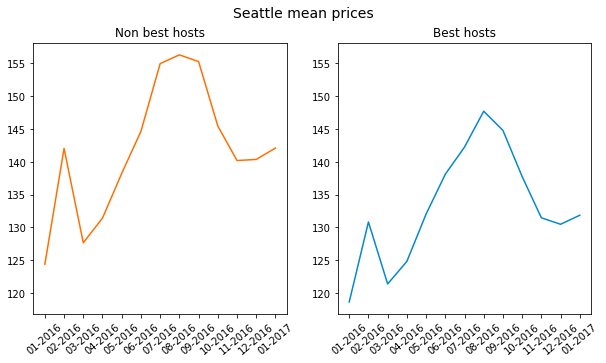

In [154]:
# Plot the mean prices of both datasets
fig = plt.figure(figsize=(10,5))
fig.suptitle("Seattle mean prices", fontsize=14)

ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Non best hosts")
y = rest_cal.loc[seattle_calendar['available']=='t', ['year_month', 'norm_price']].groupby(['year_month']).mean()
x2 = rest_cal['year_month'].unique()
# ['2016-01-15', '2016-02-15', '2016-03-15', '2016-04-15', '2016-05-15', '2016-06-15', '2016-07-15', '2016-08-15',
#      '2016-09-15', '2016-10-15', '2016-11-15', '2016-12-15']
N = len(x2)
xx = np.arange(N)

plt.plot(xx, y, color='#FF6F00')
plt.xticks(xx, x2, rotation=40)

ax2 = fig.add_subplot(1,2,2, sharey=ax1)
ax2.set_title("Best hosts")
y = best_cal.loc[seattle_calendar['available']=='t', ['year_month', 'norm_price']].groupby(['year_month']).mean()
x2 = best_cal['year_month'].unique()
# ['2016-01-15', '2016-02-15', '2016-03-15', '2016-04-15', '2016-05-15', '2016-06-15', '2016-07-15', '2016-08-15',
#      '2016-09-15', '2016-10-15', '2016-11-15', '2016-12-15']
N = len(x2)
xx = np.arange(N)

plt.plot(xx, y, color='#0288D1')
plt.xticks(xx, x2, rotation=40)

plt.show()

 - What is the mean occupation of the apartments?

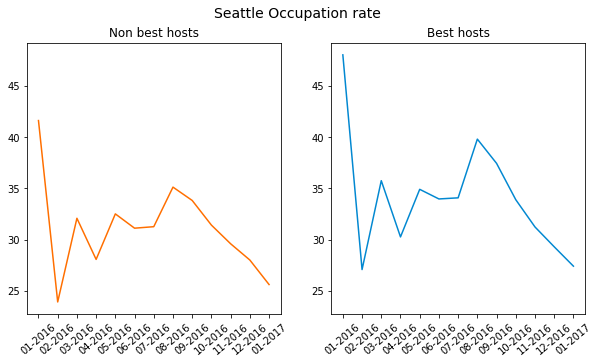

In [155]:
# Plot the occupation ratio of both datasets
fig = plt.figure(figsize=(10,5))
fig.suptitle("Seattle Occupation rate", fontsize=14)

ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Non best hosts")
y = rest_cal[['Occupied', 'year_month']].groupby(['year_month']).sum()/rest_cal[['Occupied', 'year_month']].groupby(['year_month']).count()*100
x2 = rest_cal['year_month'].unique()
N = len(x2)
xx = np.arange(N)

plt.plot(xx, y, color='#FF6F00')
plt.xticks(xx, x2, rotation=40)

ax2 = fig.add_subplot(1,2,2, sharey=ax1)
ax2.set_title("Best hosts")
y = best_cal[['Occupied', 'year_month']].groupby(['year_month']).sum()/best_cal[['Occupied', 'year_month']].groupby(['year_month']).count()*100
x2 = best_cal['year_month'].unique()
N = len(x2)
xx = np.arange(N)

plt.plot(xx, y, color='#0288D1')
plt.xticks(xx, x2, rotation=40)

plt.show()

 - Which are the most important words in the comments the roomers leave?

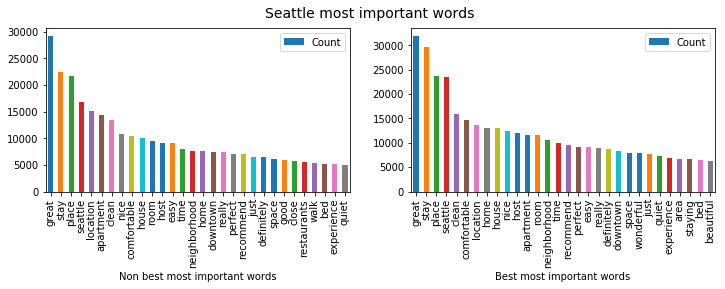

In [156]:
# Plot the most important words
fig, axes = plt.subplots(figsize=(12,3),nrows=1, ncols=2)
fig.suptitle("Seattle most important words", fontsize=14)

df_rest.plot.bar(x='Non best most important words',y='Count', ax=axes[0])
df_best.plot.bar(x='Best most important words',y='Count', ax=axes[1])

plt.show()

- Is there a difference between the geographical distribution of the best hosts and the others?

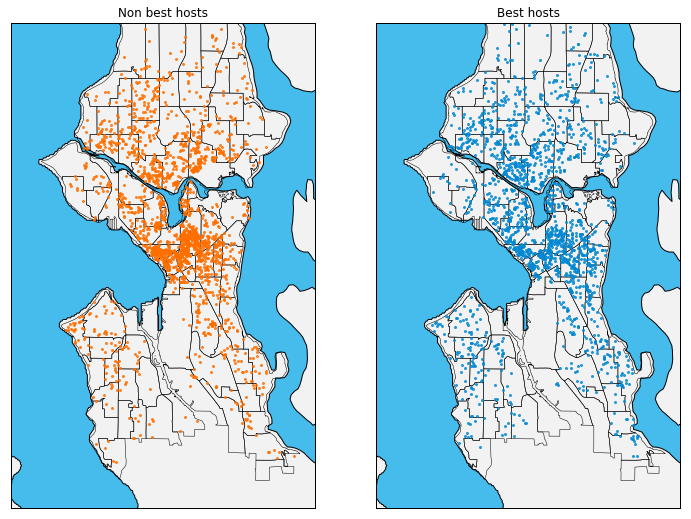

In [157]:
# Plot a map with the location of the hosts
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,2,1)
ax.set_title("Non best hosts")
m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc',
            lat_0=47.5, lon_0=-122.3,
            llcrnrlon=-122.459694, llcrnrlat= 47.481003, urcrnrlon=-122.224434, urcrnrlat=47.734135)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('WGS84/Neighborhoods', 'areas')

lon = seattle_rest.longitude.values
lat = seattle_rest.latitude.values
x,y = m(lon, lat)
m.plot(x, y, 'o', markersize=2, color='#FF6F00', alpha=0.8)

ax = fig.add_subplot(1,2,2)
ax.set_title("Best hosts")
m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc',
            lat_0=47.5, lon_0=-122.3,
            llcrnrlon=-122.459694, llcrnrlat= 47.481003, urcrnrlon=-122.224434, urcrnrlat=47.734135)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('WGS84/Neighborhoods', 'areas')

lon = seattle_best.longitude.values
lat = seattle_best.latitude.values
x,y = m(lon, lat)
m.plot(x, y, 'o', markersize=2, color='#0288D1', alpha=0.8)

plt.show()    